In [1]:
from pmotifs.analysis_utilities.loading import Result
from pmotifs.config import config

GRAPHLET_SIZE = 3

r = Result.load_result(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    GRAPHLET_SIZE,
)

g = r.pmotif_graph
df = r.positional_metric_df

Loading graph modules: 100%|████████████████| 27/27 [00:00<00:00, 147264.25it/s]


In [2]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

# Analysis

In [3]:
from statistics import quantiles

def elements_in_percentile(elements, percentile, above=True):
    elements = sorted(elements)
    
    percentile_cuts = quantiles(elements, n=100, method="inclusive")
    cutoff = percentile_cuts[percentile - 1]

    comparator = lambda e: e > cutoff
    if not above:
        comparator = lambda e: e < cutoff
        
    return [e for e in elements if comparator(e)]


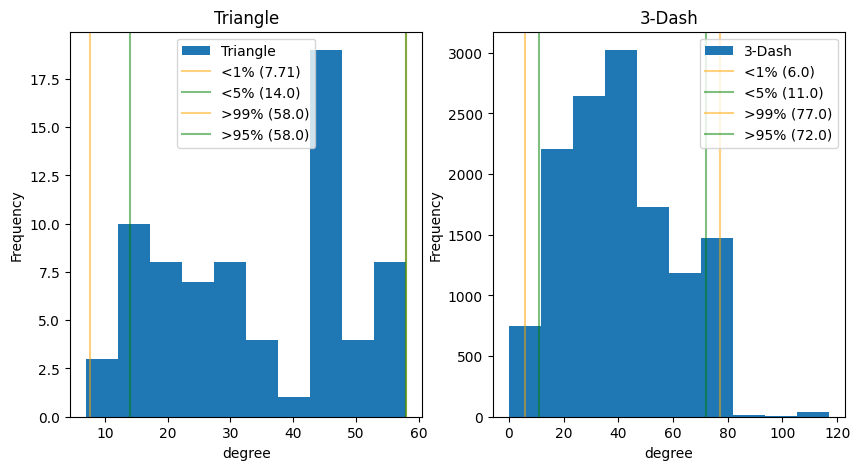

In [4]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name

METRIC_NAME = "degree"

fig, axes = plt.subplots(1, len(graphlet_classes), figsize=(len(graphlet_classes) * 5, 5))

for i, graphlet_class in enumerate(graphlet_classes):
    ax = axes[i]

    metric = df[df["graphlet_class"] == graphlet_class][METRIC_NAME]
        
    percentile_cuts = quantiles(metric, n=100, method="inclusive")
    
    ax.hist(metric, label=graphlet_class_to_name(graphlet_class))
    ax.axvline(percentile_cuts[0], label=f"<1% ({percentile_cuts[0]})", color="orange", alpha=0.5)
    ax.axvline(percentile_cuts[4], label=f"<5% ({percentile_cuts[4]})", color="green", alpha=0.5)
    ax.axvline(percentile_cuts[-1], label=f">99% ({percentile_cuts[-1]})", color="orange", alpha=0.5)
    ax.axvline(percentile_cuts[-5], label=f">95% ({percentile_cuts[-5]})", color="green", alpha=0.5)
    
    
    ax.legend()
    ax.set_xlabel(METRIC_NAME)
    ax.set_ylabel("Frequency")
    ax.set_title(graphlet_class_to_name(graphlet_class))

In [5]:
"""Prepare Graph Plotting"""
import networkx as nx

from pmotifs.analysis_utilities.plotting import prepare_kamada_kawai_layout_with_multiple_components


nx_g = g.load_graph()
pos = prepare_kamada_kawai_layout_with_multiple_components(nx_g)

In [6]:
def get_quantile_filters(metric_name, graphlet_df):
    metric = graphlet_df[metric_name]
    percentile_cuts = quantiles(metric, n=100, method="inclusive")

    below_1p = lambda e: e < percentile_cuts[0]
    below_5p = lambda e: e < percentile_cuts[4]

    above_1p = lambda e: e > percentile_cuts[-1]
    above_5p = lambda e: e > percentile_cuts[-5]

    return {
        "below_1p": below_1p,
        "below_5p": below_5p,
        "above_1p": above_1p,
        "above_5p": above_5p,
    }

In [7]:
def filter_motifs_by_quantile(graphlet_df, quantile_name, quantile_filters=None):
    if quantile_filters is None:
        quantile_filters = get_quantile_filters(METRIC_NAME, graphlet_df)
    
    kept_positions = [
        quantile_filters[quantile_name](e)
        for e in graphlet_df[METRIC_NAME]
    ]
    
    return list(graphlet_df[kept_positions]["nodes"])

In [8]:
from pmotifs.graphlet_representation import graphlet_name_to_class
from pmotifs.analysis_utilities.plotting import plot_graph_with_motif_highlight


def plot_single(graphlet_class_name, quantile_filter_name):
    graphlet_class = graphlet_name_to_class(graphlet_class_name)
    
    graphlet_class_df = df[df["graphlet_class"] == graphlet_class]
    
    fig, ax= plt.subplots(1, 1, figsize=(10, 10))

    interesting_motifs = filter_motifs_by_quantile(
        graphlet_class_df,
        quantile_filter_name,
    )

    plot_graph_with_motif_highlight(
        nx_g,
        interesting_motifs,
        pos,
        ax,
        title=f"{quantile_filter_name} ({len(interesting_motifs)})",
    )

    fig.suptitle(graphlet_class_to_name(graphlet_class))

In [9]:
import networkx as nx


def plot_quantiles(graphlet_class):
    graphlet_class_df = df[df["graphlet_class"] == graphlet_class]

    quantile_filters = get_quantile_filters(METRIC_NAME, graphlet_class_df)


    fig, axes = plt.subplots(1,len(quantile_filters), figsize=(20,5,))

    for i, quantile_filter_name in enumerate(quantile_filters):
        ax = axes[i]

        interesting_motifs = filter_motifs_by_quantile(
            graphlet_class_df,
            quantile_filter_name,
            quantile_filters=quantile_filters,
        )

        plot_graph_with_motif_highlight(
            nx_g,
            interesting_motifs,
            pos,
            ax,
            title=f"{quantile_filter_name} ({len(interesting_motifs)})",
        )

    fig.suptitle(graphlet_class_to_name(graphlet_class))

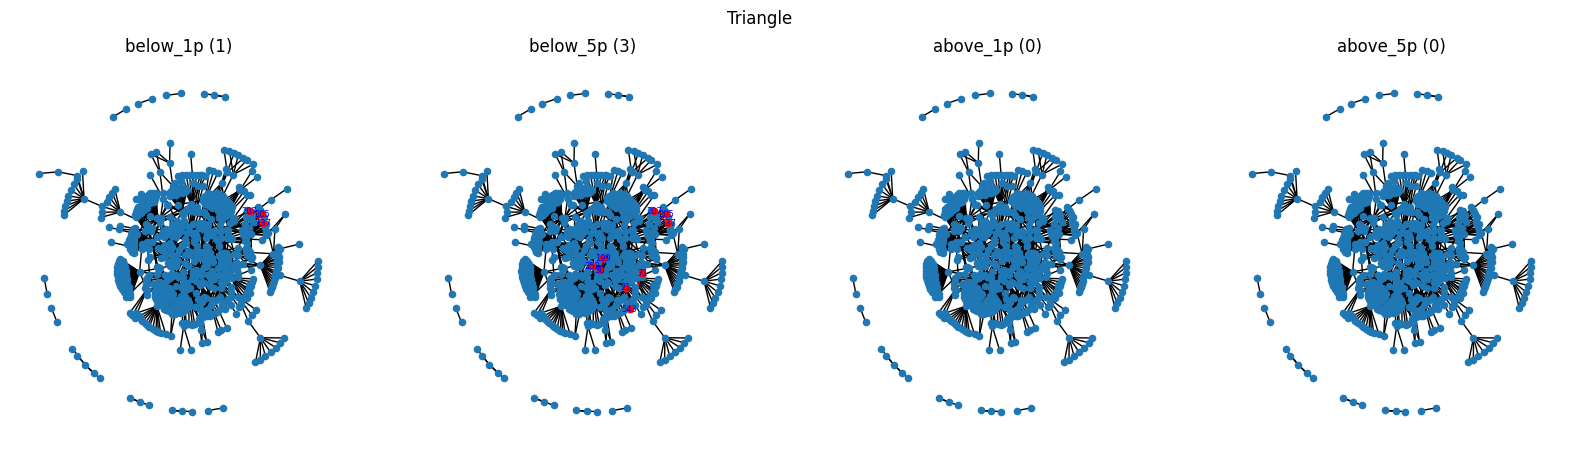

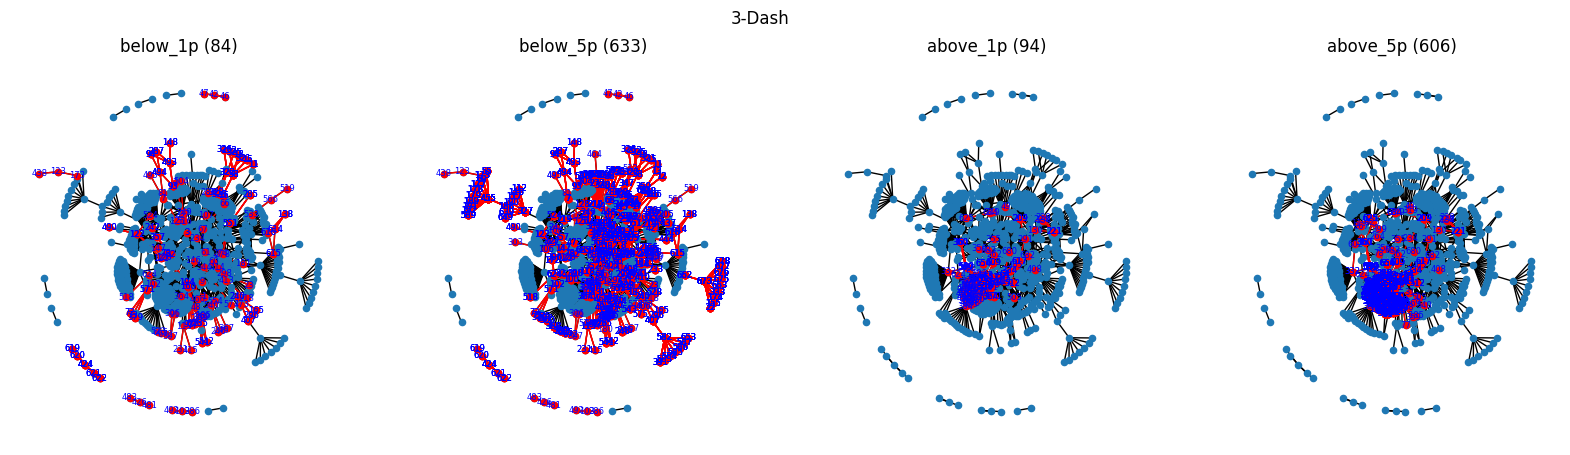

In [10]:
for graphlet_class in graphlet_classes:
    plot_quantiles(graphlet_class)

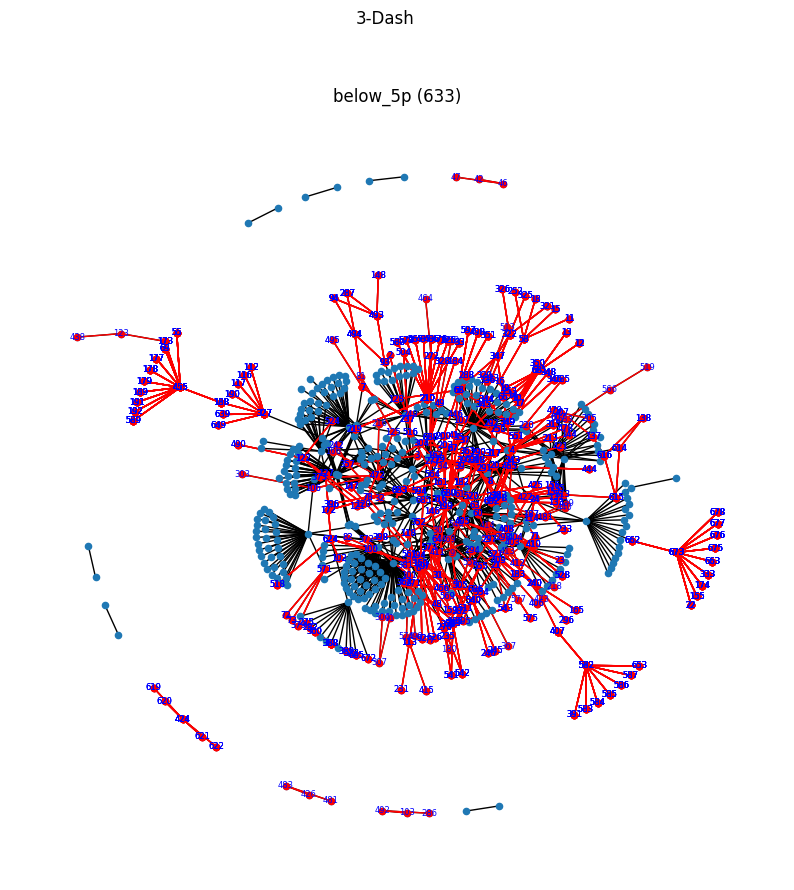

In [11]:
plot_single(graphlet_class_name="3-Dash", quantile_filter_name="below_5p")